<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
from pandas import DataFrame
from os import path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
train_dir = "./train_dataset"
test_dir = "./test_dataset"
label_filename = path.join(train_dir, "train_labels.csv")
train_img_dir = path.join(train_dir,"train")
test_img_dir = path.join(test_dir,"test")

In [3]:
labels = pd.read_csv(label_filename, index_col=0)
labels['filename'] = labels.index.astype(str) + ".jpg"
#labels['filename'] = labels.apply(lambda row: path.join(dataset, row.name.astype(str)+".jpg"), axis=1)

In [4]:
labels.head()

,invasive,filename
name,,
1,0,1.jpg
2,0,2.jpg
3,1,3.jpg
4,0,4.jpg
5,1,5.jpg


In [5]:
SEED=42
TARGET_SIZE=(128,128)
BATCHSIZE = 32

In [6]:
labels_train,labels_valid = train_test_split(labels, test_size=0.2, random_state=SEED)

In [7]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.05,
                                   zoom_range=[0.7,0.9],
                                   rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_noaugment = ImageDataGenerator(rescale=1./255)
options = {'directory': train_img_dir,
           'x_col': "filename",
           'y_col': "invasive",
           'batchsize': BATCHSIZE,
           'class_mode': "raw",  
           'target_size': TARGET_SIZE,
           'seed': SEED
          }

train_generator = train_datagen.flow_from_dataframe(dataframe=labels_train, shuffle=True, **options)
valid_generator = train_datagen.flow_from_dataframe(dataframe=labels_valid, shuffle=False, **options)
noaugment_generator = train_datagen_noaugment.flow_from_dataframe(dataframe=labels_train, shuffle=False, **options)

Found 1836 validated image filenames.
Found 459 validated image filenames.
Found 1836 validated image filenames.


In [ ]:
image = next(train_generator)[0]

plt.figure(figsize=(10,8))
for i in range(3):
    for j in range(3):
        idx = 3*i+j
        plt.subplot(3,3,idx+1)
        plt.imshow(image[idx])
plt.show()

In [8]:
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.metrics import AUC

In [9]:
def build_model(size=(64,64)):
    return Sequential([
        Input(shape=(size[0],size[1],3)),
        Conv2D(16,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(32,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128,(3,3)),
        Activation('relu'),
        GlobalMaxPooling2D(),
        Dropout(rate=0.2),
        Dense(16),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
    ])

In [10]:
model = build_model(size=TARGET_SIZE)

In [9]:
loss='binary_crossentropy'
metrics=[AUC()]
LEARNING_RATE = 0.01
EPOCHS = 30

In [11]:
model = build_model(size=TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
activation_6 (Activation)    (None, 94, 94, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
activation_7 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)       

In [12]:
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 15 steps
Epoch 1/5
58/58 [==============================] - 34s 589ms/step - loss: 0.6480 - auc: 0.5959 - val_loss: 0.6107 - val_auc: 0.8325
Epoch 2/5
58/58 [==============================] - 32s 555ms/step - loss: 0.5870 - auc: 0.7552 - val_loss: 0.5721 - val_auc: 0.7674
Epoch 3/5
58/58 [==============================] - 33s 572ms/step - loss: 0.5645 - auc: 0.7627 - val_loss: 0.5279 - val_auc: 0.8376
Epoch 4/5
58/58 [==============================] - 32s 554ms/step - loss: 0.5384 - auc: 0.8066 - val_loss: 0.5345 - val_auc: 0.8238
Epoch 5/5
58/58 [==============================] - 32s 544ms/step - loss: 0.5004 - auc: 0.8396 - val_loss: 0.4300 - val_auc: 0.9087


In [11]:
# def plot_history(history):
#     pd.DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
#     plt.grid(True)
#     #plt.gca().set_ylim(0, 1)
#     plt.title('Model performance throughout training')
#     plt.ylabel('Loss')
#     plt.xlabel('epoch')
#     plt.show()
    
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    fig = plt.figure(figsize=(15,8))
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = fig.add_subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        ax.grid(True)
        ax.set_title(f'Model performance throughout training ({metric})')
        ax.set_xlabel('epoch')
    return fig

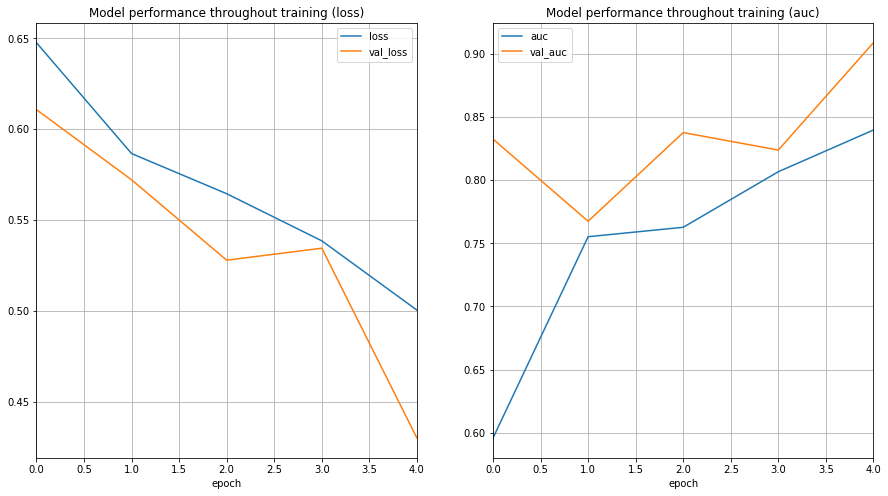

In [29]:
plot_history(history, val=True, metrics=['loss', 'auc']);

In [15]:
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [16]:
y_valid.shape, y_pred_valid.shape

((459,), (459, 1))

In [17]:
from tensorflow import math
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score

In [10]:
def plot_roc_curve(fpr, tpr, thresholds):
    fig = plt.figure(figsize=(14,6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.plot(fpr, thresholds, 'r--', label='threshold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])

    plt.legend(loc="lower right")
    #return fig

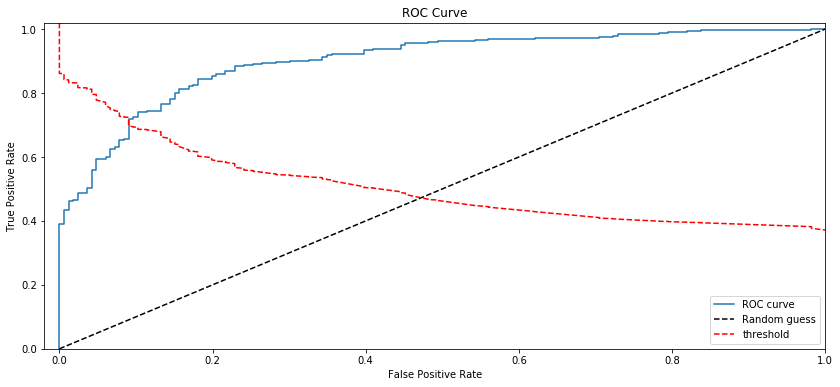

AUC: 0.9003248488835889


In [59]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
plot_roc_curve(fpr, tpr, thresholds)
plt.show()
print(f"AUC: {auc(fpr, tpr)}")

In [ ]:
y_pred_train = model.predict_generator(noaugment_generator)

In [ ]:
pred_df = pd.DataFrame()
y_train = labels_train['invasive']
pred_df['label'] = labels_train['invasive']
pred_df['pred_proba'] = y_pred_train

#pred_df['label'] = labels_valid['invasive']
#pred_df['pred_proba'] = y_pred_valid

pred_df = pred_df.sort_values(by='pred_proba')

total=pred_df.shape[0]
n_positive = (pred_df['label'] == 1).sum()
n_negative = (pred_df['label'] == 0).sum()

pred_df['FP'] = pred_df['label'].cumsum()
pred_df['TP'] = n_positive - pred_df['FP']
pred_df['TN'] = (1-pred_df['label']).cumsum() 
pred_df['FN'] = n_negative - pred_df['TN']

total=pred_df.shape[0]

pred_df['accuracy'] = (pred_df['TN'] + pred_df['TP'])/total

pred_df = pred_df.reset_index()

idx_max = pred_df['accuracy'].idxmax()
best_thres = (pred_df['pred_proba'][idx_max]+pred_df['pred_proba'][idx_max+1])/2

best_thres = pred_df['accuracy'].sort_values().head(pred_df.shape[0]//100).mean()

print(f"Threshold: {best_thres}")
#print(f"Train Accuracy: {pred_df['accuracy'][idx_max]}")
print(f"Train Accuracy: {accuracy_score(y_train, (y_pred_train >=best_thres).astype(int))}")
print(f"Valid Accuracy: {accuracy_score(y_valid, (y_pred_valid >=best_thres).astype(int))}")

In [ ]:
pred_df.sort_values(by='accuracy', ascending=False).head()

In [ ]:
y_pred_valid_class = (y_pred_valid >= best_thres).astype(int)
conf_matrix = math.confusion_matrix(y_valid,y_pred_valid_class>0.7)
sns.heatmap(data=conf_matrix, annot=True, fmt="d")
plt.show()

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [12]:
def build_VGG16(size=(64,64)):
    model = VGG16(weights= 'imagenet', include_top=False, input_shape=(size[0],size[1],3))
    
    for layer in model.layers:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(128)(output)
    output = Activation('relu')(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    
    model = Model(model.input, output)
    return model

In [15]:
model = build_VGG16(TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
EPOCHS = 10
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 15 steps
Epoch 1/10
58/58 [==============================] - 118s 2s/step - loss: 0.5574 - auc: 0.7786 - val_loss: 0.3745 - val_auc: 0.9196
Epoch 2/10
58/58 [==============================] - 119s 2s/step - loss: 0.3983 - auc: 0.8917 - val_loss: 0.3078 - val_auc: 0.9328
Epoch 3/10
58/58 [==============================] - 117s 2s/step - loss: 0.3752 - auc: 0.9056 - val_loss: 0.2953 - val_auc: 0.9411
Epoch 4/10
58/58 [==============================] - 118s 2s/step - loss: 0.3475 - auc: 0.9187 - val_loss: 0.3003 - val_auc: 0.9392
Epoch 5/10
58/58 [==============================] - 125s 2s/step - loss: 0.3407 - auc: 0.9213 - val_loss: 0.2698 - val_auc: 0.9537
Epoch 6/10
58/58 [==============================] - 122s 2s/step - loss: 0.3393 - auc: 0.9235 - val_loss: 0.2887 - val_auc: 0.9451
Epoch 7/10
54/58 [==========================>.

In [ ]:
plot_history(history, metrics=['loss', 'auc'], val=True)

In [ ]:
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
print_roc_curve(fpr, tpr, thresholds)
print(f"AUC: {auc(fpr, tpr)}")

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
def build_InceptionV3(size=(64,64)):
    model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(size[0],size[1],3))
    
    for layer in model.layers:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dropout(rate=0.3)(output)
    output = Dense(128)(output)
    output = Activation('relu')(output)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    
    model = Model(model.input, output)
    return model

In [ ]:
model = build_InceptionV3(TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

In [ ]:
EPOCHS = 10
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

In [ ]:
plot_history(history, metrics=['loss', 'auc'], val=True)
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
print_roc_curve(fpr, tpr, thresholds)
print(f"AUC: {auc(fpr, tpr)}")